In [1]:
import os, os.path 
import numpy 
from torch.utils.data import Dataset, DataLoader
import pickle
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib

"""Change to the data folder"""
train_path = "./new_train/new_train"
test_path = './new_val_in/new_val_in'
matplotlib.rcParams['savefig.dpi'] = 300

In [6]:
sum(list(range(36 + 1, 36 + 60 + 1)))

3990

In [2]:
class ArgoverseDataset(Dataset):
    
    """Dataset class for Argoverse"""
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform
        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self): #len(val_dataset)
        return len(self.pkl_list)
    
    def __getitem__(self, idx): #val_dataset[0]
        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
        if self.transform:
            data = self.transform(data)
        return data

In [3]:
train_dataset = ArgoverseDataset(data_path=train_path) 
test_dataset  = ArgoverseDataset(data_path=test_path) 

In [4]:
# #original points

# in_train, out_train = [], []
# for i in tqdm(range((len(train_dataset)))):
#     val = train_dataset[i]
#     c_filter = val['car_mask'].reshape(-1) == 1
#     p_in = val['p_in'][c_filter]
#     v_in = (val['v_in'][c_filter][:, :, 0]**2 + val['v_in'][c_filter][:, :, 1] ** 2)**0.5
#     v_out = (val['v_out'][c_filter][:, :, 0]**2 + val['v_out'][c_filter][:, :, 1] ** 2)**0.5
#     p_out = val['p_out'][c_filter]
#     for c in range(len(p_in)):
#         inp = np.hstack((v_in[c].reshape(19, 1), p_in[c])).flatten()
#         in_train.append(inp)
#         out = np.hstack((v_out[c].reshape(30, 1), p_out[c])).flatten()
#         out_train.append(out)
# in_train = np.array(in_train)
# out_train = np.array(out_train)

In [5]:
#diff points

train = []
for i in tqdm(range((len(train_dataset)))):
    val = train_dataset[i]
    c_filter = val['car_mask'].reshape(-1) == 1
    p_in = val['p_in'][c_filter]
    p_out = val['p_out'][c_filter]
    for c in range(len(p_in)):
        in_out = np.diff(np.vstack((p_in[c], p_out[c])), axis=0).flatten()
        train.append(in_out)
train = np.array(train)

In [8]:
in_train, out_train = train[:, :36], train[:, 36:]

In [9]:
in_train.shape, out_train.shape

((1812171, 36), (1812171, 60))

# Train

In [10]:
from sklearn.neural_network import MLPRegressor

In [11]:
#create only targeted agent list
init_p = []
in_test = []
for i in tqdm(range((len(test_dataset)))):
    val = test_dataset[i]
    c_filter = val['agent_id'] == val['track_id'][:, 0, 0]
    p_in = val['p_in'][c_filter]
    v_in = (val['v_in'][c_filter][:, :, 0]**2 + val['v_in'][c_filter][:, :, 1] ** 2)**0.5
    for c in range(len(p_in)):
        in_test.append(
            np.diff(p_in[c], axis=0).flatten()
        )
        init_p.append(
            p_in[c][-1]
        )
in_test = np.array(in_test)
init_p = np.array(init_p)

In [12]:
in_test.shape, init_p.shape

((3200, 36), (3200, 2))

In [16]:
#auto regressive and teacher-forcing

#prepare a list of 60 linear regression models, half for 30 output x, half for 30 output y

num_output = 60
input_end_idx = 36

regs = [None] * num_output

#train using labels from the ground truth output, and use the GT output to train new time point
for i in tqdm(range(num_output)):
    #regs[i] = MLPRegressor(random_state=1, hidden_layer_sizes=10, max_iter=20, batch_size=500).fit(in_train, out_train[:, i])
    regs[i] = LinearRegression().fit(in_train, out_train[:, i])
    #append GT back to the train feature
    in_train = np.insert(in_train, input_end_idx + i, out_train[:, i], axis=1)

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


KeyboardInterrupt: 

In [33]:
for i in tqdm(range(num_output)):
    pred = regs[i].predict(in_test)
    in_test = np.insert(in_test, input_end_idx + i, pred, axis=1)

In [41]:
pred = in_test[:, input_end_idx:]

In [42]:
pred

array([[ 0.89229534,  0.85426171,  0.93187133, ...,  0.90401191,
         0.88392139,  0.89112875],
       [ 0.00174933, -0.32648074, -0.04431245, ..., -0.17252194,
        -0.07330664, -0.16939675],
       [ 0.20456159, -0.03993083,  0.21618458, ..., -0.078703  ,
         0.20837796, -0.07665519],
       ...,
       [-0.14647564,  0.32343838, -0.16150715, ...,  0.26496804,
        -0.14666128,  0.25724155],
       [-0.08724574, -0.23695208, -0.09013251, ..., -0.22718565,
        -0.10586434, -0.22248741],
       [ 0.07038408, -1.05755761,  0.05887728, ..., -0.88509574,
         0.02256564, -0.86912755]])

In [43]:
x_pred = pred[:, list(range(0, 60, 2))]
y_pred = pred[:, list(range(1, 61, 2))]

In [47]:
x_pred[:, 0] = x_pred[:, 0] + init_p[:, 0]

In [48]:
y_pred[:, 0] = y_pred[:, 0] + init_p[:, 1]

In [53]:
x_pred = x_pred.cumsum(1)
y_pred = y_pred.cumsum(1)

In [62]:
df = np.zeros((3200, 60))
num = 0
for i in range(30):
    df[:, num] = x_pred[:, i]
    df[:, num + 1] = y_pred[:, i]
    num += 2

In [64]:
df = pd.DataFrame(df)

In [69]:
in_test

array([[ 0.85986328,  0.92837524,  0.92272949, ...,  0.90401191,
         0.88392139,  0.89112875],
       [ 0.08538818, -0.36047363, -0.09686279, ..., -0.17252194,
        -0.07330664, -0.16939675],
       [-0.15307617,  0.10327148,  0.22485352, ..., -0.078703  ,
         0.20837796, -0.07665519],
       ...,
       [-0.16052246,  0.33877563, -0.14453125, ...,  0.26496804,
        -0.14666128,  0.25724155],
       [-0.0199585 , -0.09765625,  0.00311279, ..., -0.22718565,
        -0.10586434, -0.22248741],
       [ 0.36474609, -1.75976562,  0.03778076, ..., -0.88509574,
         0.02256564, -0.86912755]])

In [65]:
df

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,1714.754966,337.152998,1715.686838,338.062887,1716.616465,338.982253,1717.519850,339.857041,1718.448177,340.765761,...,1737.874578,360.088961,1738.780519,360.999062,1739.684379,361.901338,1740.582790,362.805350,1741.466711,363.696479
1,725.538248,1229.634701,725.493936,1229.383913,725.434163,1229.147938,725.375130,1228.925168,725.319084,1228.706772,...,723.813600,1224.653576,723.736452,1224.476419,723.660653,1224.302618,723.587294,1224.130096,723.513988,1223.960699
2,574.008883,1244.649522,574.225067,1244.577632,574.438119,1244.496274,574.660810,1244.425675,574.879038,1244.345709,...,579.507831,1242.623227,579.729951,1242.543056,579.950492,1242.462806,580.161826,1242.384103,580.370204,1242.307448
3,1691.328821,315.587190,1691.953164,316.155109,1692.573282,316.724180,1693.205602,317.312384,1693.831289,317.892548,...,1706.920017,330.100088,1707.535061,330.675879,1708.145286,331.249256,1708.746527,331.816992,1709.339794,332.373452
4,2122.795843,677.107997,2121.521643,676.005512,2120.253507,674.913263,2118.996030,673.829908,2117.718326,672.724519,...,2091.466030,649.657955,2090.244000,648.571481,2089.027628,647.491582,2087.827163,646.424308,2086.645987,645.367931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,256.403337,805.453735,256.627745,805.260426,256.861576,805.060293,257.096856,804.857556,257.332394,804.650381,...,262.509477,800.202817,262.757579,799.993188,263.002799,799.785176,263.244069,799.579707,263.485228,799.379496
3196,587.854537,1153.992771,587.884850,1153.377223,587.909963,1152.738283,587.935036,1152.082064,587.966248,1151.442510,...,588.540362,1137.838276,588.562673,1137.194338,588.585903,1136.559752,588.609307,1135.935195,588.630456,1135.320296
3197,1755.590097,444.188703,1755.428589,444.503122,1755.266447,444.813995,1755.103499,445.117049,1754.941840,445.424448,...,1751.610729,451.458892,1751.456961,451.726893,1751.304201,451.998696,1751.155433,452.263664,1751.008772,452.520906
3198,574.617161,1288.840440,574.527028,1288.617821,574.438179,1288.406879,574.349573,1288.197326,574.253522,1287.976841,...,572.080557,1283.233384,571.974399,1283.004593,571.865662,1282.776034,571.758112,1282.548849,571.652247,1282.326361


In [66]:
df.insert(0, 'ID', pd.read_csv('sample_submission.csv')['ID'])

In [67]:
df.columns = pd.read_csv('sample_submission.csv').columns

In [68]:
df.to_csv('submission.csv', index=False)

# Prediction of Train data vs. ground truth

In [74]:
lst = [21, 27, 5333, 31211, 31666, 39405]

In [75]:
#create only targeted agent list

random = []
truth = []
for i in lst:
    val = train_dataset[i]
    p_in = val['p_in'][val['agent_id'] == val['track_id'][:, 0, 0]]
    p_out = val['p_out'][val['agent_id'] == val['track_id'][:, 0, 0]]
    for c in range(len(p_in)):
        random.append(p_in[c].reshape(19*2))
        truth.append(p_out[c].reshape(30*2))
random = np.array(random)
truth = np.array(truth)

In [76]:
for i in tqdm(range(60)):
    pred = regs[i].predict(random)
    random = np.insert(random, 38 + i, pred, axis=1)

In [77]:
prediction = random[:, -60:]

In [78]:
truth[0].shape, prediction[0].shape

((60,), (60,))

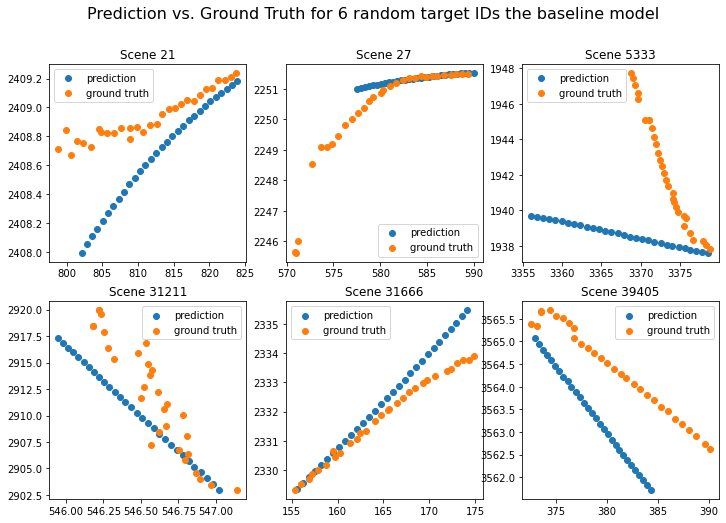

In [81]:
num = 0
fig, axs = plt.subplots(2, 3, figsize = (12, 8))
for i in range(2):
    for j in range(3):
        axs[i, j].scatter(prediction[num][::2], prediction[num][1::2], label='prediction')
        axs[i, j].scatter(truth[num][::2], truth[num][1::2], label='ground truth')
        axs[i, j].set_title(f"Scene {lst[num]}")
        axs[i, j].legend()
        num += 1
fig.suptitle('Prediction vs. Ground Truth for 6 random target IDs the baseline model', fontsize=16)
fig.savefig("prediction_sample.png")
fig.show()

In [2]:
import pandas as pd
pd.read_csv("submission.csv").iloc[15:20]

,ID,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v51,v52,v53,v54,v55,v56,v57,v58,v59,v60
15,10196,2140.634430,811.519764,2141.037733,811.077851,2141.450452,810.617266,2141.855869,810.164880,2142.260882,...,2150.638153,800.552708,2151.028615,800.139758,2151.412323,799.724014,2151.787364,799.317293,2152.158770,798.925578
16,10200,2163.191190,780.077495,2163.908063,779.114778,2164.628585,778.054576,2165.335401,776.924753,2166.058187,...,2180.897898,751.775358,2181.580331,750.629811,2182.254052,749.494803,2182.921828,748.379527,2183.577535,747.296778
17,10214,2161.455370,813.337710,2161.178158,813.018274,2160.899755,812.699652,2160.619449,812.375713,2160.350887,...,2154.977888,806.195495,2154.730439,805.934402,2154.486315,805.672852,2154.248942,805.425767,2154.013313,805.180185
18,10219,726.577571,1522.612585,727.032241,1522.656070,727.478982,1522.679629,727.941341,1522.713233,728.404263,...,738.155012,1523.543698,738.616710,1523.590244,739.079559,1523.639951,739.531742,1523.690206,739.977852,1523.738766
19,10232,2084.028008,650.293136,2082.582167,649.290328,2081.115281,648.264777,2079.531037,647.124722,2077.997957,...,2046.374950,624.262211,2044.873036,623.234653,2043.396824,622.218342,2041.949006,621.219383,2040.529671,620.242096


# Back up method

In [ ]:
# Method 2. Seperate x and y to train 30 * 2 = 60 models

x_in_train = in_train[:, list(range(0, 38, 2))]
y_in_train = in_train[:, list(range(1, 39, 2))]
x_out_train = out_train[:, list(range(0, 60, 2))]
y_out_train = out_train[:, list(range(1, 61, 2))]

# Training 

x_regs = [LinearRegression()] * 30

for i in tqdm(range(30)):
    x_regs[i] = LinearRegression().fit(x_in_train, x_out_train[:, i])
    x_in_train = np.insert(x_in_train, 19 + i, x_out_train[:, i], axis=1)

y_regs = [LinearRegression()] * 30

for i in tqdm(range(30)):
    y_regs[i] = LinearRegression().fit(y_in_train, y_out_train[:, i])
    y_in_train = np.insert(y_in_train, 19 + i, y_out_train[:, i], axis=1)

#random forest regressor?
x_regs = [RandomForestRegressor()] * 30
y_regs = [RandomForestRegressor()] * 30

for i in tqdm(range(30)):
    
    x_regs[i] = RandomForestRegressor().fit(x_in_train, x_out_train[:, i])
    x_in_train = np.insert(x_in_train, 19 + i, x_out_train[:, i], axis=1)

    y_regs[i] = RandomForestRegressor().fit(y_in_train, y_out_train[:, i])
    y_in_train = np.insert(y_in_train, 19 + i, y_out_train[:, i], axis=1)

# Predicting

in_test = []
for i in tqdm(range((len(test_dataset)))):
    val = test_dataset[i]
    p_in = val['p_in'][test_dataset[0]['agent_id'] == test_dataset[0]['track_id'][:, 0, 0]]
    for c in range(len(p_in)):
        in_test.append(p_in[c].reshape(19*2))
in_test = np.array(in_test)

in_test.shape

x_regs[0].coef_.shape

x_in_test = in_test[:, list(range(0, 38, 2))]
y_in_test = in_test[:, list(range(1, 39, 2))]

for i in tqdm(range(30)):
    pred = x_regs[i].predict(x_in_test)
    x_in_test = np.insert(x_in_test, 19 + i, pred, axis=1)

for i in tqdm(range(30)):
    pred = y_regs[i].predict(y_in_test)
    y_in_test = np.insert(y_in_test, 19 + i, pred, axis=1)

df = pd.read_csv('sample_submission.csv')
df

for i in tqdm(range(3200)):
    lst = []
    num = 1
    for n in range(19, 49):
        df.iloc[i, num] = x_in_test[i, n]
        num += 1
        df.iloc[i, num] = y_in_test[i, n]
        num += 1

df.to_csv('submission.csv', index=False)

df